In [1]:
import cv2
import random
import json
import time

import torch
import numpy as np
from tqdm import tqdm

import clip
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils.transforms import ResizeLongestSide 

from PIL import Image  
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from sam_caf import hyper_params_tuning, get_crops, retrieve_relevant_crop, retrieve_relevant_crop_biomed, get_sam_prompts, sam_predicton, retrieve_relevant_crop_biomed_topk

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
#config
class DictToObject:
    def __init__(self, dict_obj):
        for key, value in dict_obj.items():
            setattr(self, key, value)

config_dict = {
    "model_name" : "SAM",
    "model_type" : "vit_h",
    "source":    "False", 
    "refine" : "False",
    "pre_trained": "True", 
    "sam_ckpt":  "/data/aofei/LLM/SAM/sam_vit_h_4b8939.pth", 
    "clip_prompts": "./clip_prompts/abd_seg.json"
}

config = DictToObject(config_dict)

prompt_mode, mode = "crops", "sam_clip"

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    return image

In [3]:
import os
# os.environ["TRANSFORMERS_CACHE"]="/data/aofei/huggingface_cache/transformers"
os.environ["HF_HOME"]="/data/aofei/huggingface_cache/transformers"
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

biomed_clip_model, biomed_preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224', device="cuda")
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

clip_model, preprocess = clip.load("ViT-L/14", device="cuda")
sam_checkpoint = config.sam_ckpt

sam = sam_model_registry[config.model_type](checkpoint=sam_checkpoint)
sam.to("cuda:2")
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

dice_scores = []
mask_generator, area = hyper_params_tuning(sam)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.

In [4]:
def sam_generation(image_path):
    image = preprocess_image(image_path=image_path)
    with torch.no_grad():
        # if mode == "sam_clip":
        masks = mask_generator.generate(image)
        masks = [mask for mask in masks if mask["area"] < area] # area filtering based on area value from hyper-params tuning
        img_crops = get_crops(image, masks, prompt_mode)
        
    return masks, img_crops

def filter_sam_results(masks, img_crops):
    new_masks, new_img_crops = [], []
    for i in range(len(masks)):
        mask = masks[i]
        if mask['bbox'][0] == 0 or mask['bbox'][1] == 0:
            continue
        if mask['bbox'][2] <= 12 or mask['bbox'][3] <= 12:
            continue
        y_max, x_max = mask['bbox'][1] + mask['bbox'][3], mask['bbox'][0] + mask['bbox'][2]
        if y_max > 253 or x_max > 253:
            continue
        new_masks.append(mask)
        new_img_crops.append(img_crops[i])
    return new_masks, new_img_crops

def get_topk_similar(k, crop_scores):
    sorted_scores = sorted([(i, m) for (i,m) in enumerate(crop_scores)], key=lambda x: x[1], reverse=True)
    return sorted_scores[:k]

def get_compelete_contour(masks):
    width_list = []
    # need to consider the chest xray
    for i in masks:
        width, height = i['bbox'][2], i['bbox'][3]
        width_list.append(width)
    sorted_width = sorted([(i, m) for (i,m) in  enumerate(width_list)], key=lambda x: x[1], reverse=True)
    return sorted_width[0][1]

def judge_inner_boxes(bboxes):
    for bbox in bboxes:
        bbox

In [5]:
masks_image_dict = dict()
masks_all_image_dict = dict()
crops_image_dict = dict()
def generate_segments(query, image_path):
    if masks_image_dict.__contains__(image_path):
        masks = masks_image_dict[image_path]
        img_crops = crops_image_dict[image_path]
    else:
        masks, img_crops = sam_generation(image_path=image_path)
        masks, img_crops = filter_sam_results(masks, img_crops)
        masks_image_dict[image_path] = masks
        crops_image_dict[image_path] = img_crops
    img_crops_filtered = img_crops
    prompts = {"query": [query]}
    max_indices, scores = retrieve_relevant_crop_biomed_topk(img_crops, prompts, biomed_clip_model, biomed_preprocess, config, tokenizer=tokenizer, topk=4)
    # topk_indices = get_topk_similar(3, scores["query"])
    # define a set of rules, firstly return top3
    # if there is no explicit organs to be used as query, then just use the whole segmentation
    # if the smaller boxes are in the bigger box, then use all of them but assign higher weights on smaller inner boxes
    bboxes = []
    segs = []
    # print(max_indices)
    if max_indices is not None:
        for i in max_indices["query"]:
            bboxes.append(masks[i]["bbox"])
            segs.append(masks[i]["segmentation"])
        return bboxes, segs, max_indices["query"]
    else:
        return bboxes, segs, []


def generate_all_segments(image_path):
    if masks_all_image_dict.__contains__(image_path):
        masks = masks_all_image_dict[image_path]
    else:
        masks, img_crops = sam_generation(image_path=image_path)
        masks, img_crops = filter_sam_results(masks, img_crops)
        masks_all_image_dict[image_path] = masks
    return masks

In [6]:
import json
with open(r"/data/aofei/hallucination/CARES/HAM10000/training.json", "r") as f:
    data = json.load(f)
len(data)
all_train_data = data

In [7]:
all_train_data[0]

{'image': 'ham10000_testset/ISIC_0034761.jpg',
 'id': 'ISIC_0034761_train0',
 'conversations': [{'from': 'human',
   'value': "<image>\nWhich part of the body's skin is affected by pigmented lesion in this dermoscopy image?The candidate Options are:[A:scalp, B:ear, C:upper extremity, D:lower extremity]"},
  {'from': 'gpt', 'value': 'C:upper extremity'}]}

In [8]:
all_train_data_en = all_train_data

In [9]:
import copy
train_data_seg = copy.deepcopy(all_train_data_en)
len(train_data_seg)

400

In [10]:
len(set([i['image'] for i in train_data_seg]))

200

In [ ]:
# len(set([i['img_name'] for i in train_data]))

450

In [11]:
# for i in range(len(train_rad_data)):
#failure case: 432-3 + 100
from tqdm import tqdm
for i in tqdm(range(len(train_data_seg))):
# for i in tqdm(range(20)):
    data = train_data_seg[i]
    image_path = os.path.join("/data/aofei/hallucination/HAM10000/images", data["image"])
    question = data["conversations"][0]["value"].replace("<image>\n", "")
    question = question.split("The Question is:")[-1]
    # question = question.split("The candidate Options are:")[0]
    # print(question)
    query = f"Medical image of skin lesions. " + question

    bbox, segs, max_indices = [], [], []
    try:
        bbox, segs, max_indices = generate_segments(query, image_path)
    except:
        continue
    # print(bbox)
    data['bbox'] = bbox
    data['mask'] = segs
    data["bbox_indices"] = max_indices
    

  0%|          | 0/400 [00:00<?, ?it/s]

  1%|          | 3/400 [00:08<17:48,  2.69s/it]

Skipping zero-sized bounding box.


  4%|▎         | 14/400 [00:36<16:46,  2.61s/it]

Skipping zero-sized bounding box.


  4%|▍         | 15/400 [00:39<16:41,  2.60s/it]

Skipping zero-sized bounding box.


  8%|▊         | 34/400 [01:27<16:10,  2.65s/it]

Skipping zero-sized bounding box.


 13%|█▎        | 53/400 [02:07<10:39,  1.84s/it]

Skipping zero-sized bounding box.


 14%|█▍        | 57/400 [02:15<11:42,  2.05s/it]

Skipping zero-sized bounding box.


 17%|█▋        | 69/400 [02:39<12:33,  2.28s/it]

Skipping zero-sized bounding box.


 21%|██        | 83/400 [03:06<10:08,  1.92s/it]

Skipping zero-sized bounding box.


 25%|██▌       | 100/400 [03:41<07:37,  1.53s/it]

Skipping zero-sized bounding box.


 27%|██▋       | 108/400 [04:03<12:34,  2.58s/it]

Skipping zero-sized bounding box.


 28%|██▊       | 110/400 [04:08<12:37,  2.61s/it]

Skipping zero-sized bounding box.


 28%|██▊       | 112/400 [04:13<12:41,  2.65s/it]

Skipping zero-sized bounding box.


 32%|███▏      | 128/400 [04:43<07:23,  1.63s/it]

Skipping zero-sized bounding box.


 36%|███▋      | 145/400 [05:10<06:35,  1.55s/it]

Skipping zero-sized bounding box.


 42%|████▏     | 169/400 [05:45<06:34,  1.71s/it]

Skipping zero-sized bounding box.


 46%|████▌     | 183/400 [06:15<06:00,  1.66s/it]

Skipping zero-sized bounding box.


 48%|████▊     | 194/400 [06:28<04:53,  1.42s/it]

Skipping zero-sized bounding box.


 52%|█████▏    | 207/400 [06:52<06:35,  2.05s/it]

Skipping zero-sized bounding box.


 52%|█████▎    | 210/400 [07:00<07:37,  2.41s/it]

Skipping zero-sized bounding box.


 77%|███████▋  | 309/400 [08:23<00:59,  1.54it/s]

Skipping zero-sized bounding box.


 78%|███████▊  | 311/400 [08:26<01:10,  1.27it/s]

Skipping zero-sized bounding box.


 85%|████████▍ | 339/400 [08:48<00:27,  2.21it/s]

Skipping zero-sized bounding box.


100%|██████████| 400/400 [09:00<00:00,  1.35s/it]


In [22]:
# np.sum(train_data_seg[0]['mask'][0])
np.sum(train_data_seg[0]['mask'][1].astype(int))

211

In [12]:
s = 0
for i in train_data_seg:
    if not i.__contains__("mask"):
        s+= 1
s

2

In [13]:
train_data_seg[3]

{'image': 'ham10000_testset/ISIC_0035110.jpg',
 'id': 'ISIC_0035110_train3',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat category of pigmented skin lesion is illustrated in this dermatoscopic image?The candidate Options are:[A:benign keratosis-like lesions, B:dermatofibroma, C:basal cell carcinoma, D:melanocytic nevi]'},
  {'from': 'gpt', 'value': 'A:benign keratosis-like lesions'}],
 'bbox': [[56, 26, 116, 187],
  [52, 25, 147, 191],
  [63, 196, 17, 17],
  [25, 64, 30, 34]],
 'mask': [array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [F

In [14]:
#training2
new_train_data = []
segments_dict = dict()
for i in train_data_seg:
    template = dict()
    
    # template['answer_type'] = i['answer_type']
    template['image'] = i['image']
    template['id'] = i['id']
    template['conversations'] = []
    template['bboxes'] = []
    template['masks'] = []
    segments_dict[str(i['id'])] = []
    if i.__contains__("bbox"):
        template['bboxes'] = i["bbox"]
    if i.__contains__("mask"):
        segments_dict[str(i['id'])] = i["mask"]

    # if i.__contains__("mask"):
    #     json_ready_segments = [
    #         arr.astype(int).tolist() for arr in i["mask"]
    #     ]
    #     template['masks'] = json_ready_segments
    # template['text'] = i['question']

    # new_qa = {"from": "human", "value": i['question']}
    # new_qa2 = {"from": "gpt", "value": str(i['answer'])}
    template['conversations'] = i['conversations']
    new_train_data.append(template)

new_train_data[-6]

{'image': 'ham10000_testset/ISIC_0034610.jpg',
 'id': 'ISIC_0034610_train394',
 'conversations': [{'from': 'human',
   'value': "<image>\nAt what site on the body's skin is the lesion visible in the image situated?The candidate Options are:[A:ear, B:face, C:trunk, D:lower extremity]"},
  {'from': 'gpt', 'value': 'D:lower extremity'}],
 'bboxes': [[57, 6, 108, 162]],
 'masks': []}

In [15]:
new_train_data_top4 = []
for i in new_train_data:
    j = i.copy()
    j["bboxes"] = j["bboxes"][:4]
    new_train_data_top4.append(j)

In [16]:
new_train_data_top4[-1]

{'image': 'ham10000_testset/ISIC_0035481.jpg',
 'id': 'ISIC_0035481_train399',
 'conversations': [{'from': 'human',
   'value': '<image>\nWhat part of the body does the lesion in the image appear on?The candidate Options are:[A:trunk, B:face, C:ear, D:lower extremity]'},
  {'from': 'gpt', 'value': 'D:lower extremity'}],
 'bboxes': [[187, 231, 16, 13],
  [161, 162, 21, 39],
  [166, 162, 15, 28],
  [105, 94, 47, 64]],
 'masks': []}

In [17]:
# segments_dict['0']
ed = 0
for i in segments_dict:
    if len(segments_dict[i]) == 0:
        ed += 1
ed

16

In [18]:
# save the masks to npz file

np.savez_compressed("/data/aofei/hallucination/CARES/HAM10000/training_segments_top4.npz", **segments_dict)

In [19]:
len(new_train_data)

400

In [33]:
loaded_segments = np.load("/data/aofei/hallucination/Slake/data/training_segments.npz", allow_pickle=True)  # Allow pickle to handle lists

# Access a list of segment arrays by its ID, e.g., "id_1"
segments_list_id_1 = loaded_segments["0"]

# Each item in segments_list_id_1 is a 256x256 numpy array
for segment in segments_list_id_1:
    print(segment.shape)

(256, 256)
(256, 256)
(256, 256)
(256, 256)


In [20]:
with open('/data/aofei/hallucination/CARES/HAM10000/training_masks_top4.json', 'w') as json_file:
    json.dump(new_train_data_top4, json_file, indent=4)

In [34]:
with open('/data/aofei/hallucination/VQA_RAD/data/training_masks_top8.json', 'w') as json_file:
    json.dump(new_train_data, json_file, indent=4)

In [ ]:
with open(r"/data/aofei/hallucination/VQA-RAD/test.json", "r") as f:
    test_data = json.load(f)
len(test_data)

#training2
new_test_data = []
for i in test_data:
    if i['q_lang'] != "en":
        continue
    template = dict()
    
    # template['answer_type'] = i['answer_type']
    template['image'] = i['img_name']
    template['id'] = i['qid']
    template['answer_type'] = i['answer_type']
    template['conversations'] = []

    new_qa = {"from": "human", "value": "<image>\n" + i['question']}
    new_qa2 = {"from": "gpt", "value": str(i['answer'])}
    template['conversations'] += [new_qa, new_qa2]
    new_test_data.append(template)

In [ ]:
print(len(test_data))
with open('/data/aofei/hallucination/Slake/data/test.json', 'w') as json_file:
    json.dump(new_test_data, json_file, indent=4)

In [39]:
import json
with open(r"/data/aofei/hallucination/CARES/IU_Xray/training_masks_top4.json", "r") as f:
    seg_train_data = json.load(f)
len(seg_train_data)
# seg_train_dict = dict()
# for i in seg_train_data:
#     seg_train_dict[i['id']] = i

1783

In [23]:
with open(r"/data/aofei/hallucination/Slake/train.json", "r") as f:
    train_data = json.load(f)
len(train_data)

9835

In [24]:
train_data[1]

{'img_id': 1,
 'img_name': 'xmlab1/source.jpg',
 'question': 'Which part of the body does this image belong to?',
 'answer': 'Abdomen',
 'q_lang': 'en',
 'location': 'Abdomen',
 'modality': 'MRI',
 'answer_type': 'OPEN',
 'base_type': 'vqa',
 'content_type': 'Position',
 'triple': ['vhead', '_', '_'],
 'qid': 1}

In [25]:
num_dict = dict()
ids_dict = dict()
for i in train_data:
    organ = i['location']
    id = i['qid']
    if num_dict.__contains__(organ):
        num_dict[organ] += 1
    else:
        num_dict[organ] = 1
    
    if ids_dict.__contains__(organ):
        ids_dict[organ].append(id)
    else:
        ids_dict[organ] = [id]

In [26]:
num_dict

{'Abdomen': 3041,
 'Lung': 3406,
 'Chest_heart': 187,
 'Chest_lung': 283,
 'Brain_Tissue': 1394,
 'Brain_Face': 250,
 'Brain': 543,
 'Neck': 264,
 'Chest_mediastinal': 33,
 'Pelvic Cavity': 434}

In [27]:
train_data_lungs = []
for _id in ids_dict['Lung']:
    if seg_train_dict.__contains__(_id):
        train_data_lungs.append(seg_train_dict[_id])

In [28]:
len(train_data_lungs)

1710

In [29]:
with open('/data/aofei/hallucination/Slake/data/training_masks_top8_lung.json', 'w') as json_file:
    json.dump(train_data_lungs, json_file, indent=4)

In [30]:
train_data_lungs = []
for _id in ids_dict['Abdomen']:
    if seg_train_dict.__contains__(_id):
        train_data_lungs.append(seg_train_dict[_id])
with open('/data/aofei/hallucination/Slake/data/training_masks_top8_abd.json', 'w') as json_file:
    json.dump(train_data_lungs, json_file, indent=4)

In [ ]:
train_data[0]

In [16]:
# visualize_with_indices(image_name='xmlab1/source.jpg', indices_list=[3,0,2,1], fig_width=5)
train_data_seg[0]

{'image': 'ham10000_testset/ISIC_0035460.jpg',
 'id': 'ISIC_0035460_train0',
 'conversations': [{'from': 'human',
   'value': "<image>\nThis is a medical Question with several Options, and there is only one correct answer among these options. Please select the correct answer for the question. Remember, you can only select one option. The Question is:Which specific area of the body's surface is affected by the pigmented lesion shown in this dermatoscopic image?The candidate Options are:[A:genital, B:hand, C:back, D:trunk]\n"},
  {'from': 'gpt', 'value': 'C:back'}],
 'bbox': [[95, 179, 15, 20],
  [122, 24, 130, 163],
  [133, 96, 25, 38],
  [129, 189, 23, 18]],
 'mask': [array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, Fals

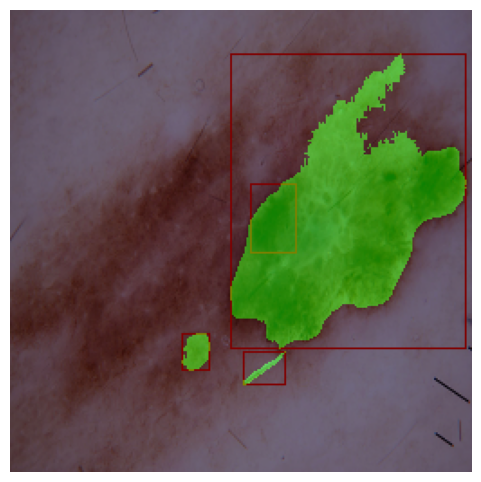

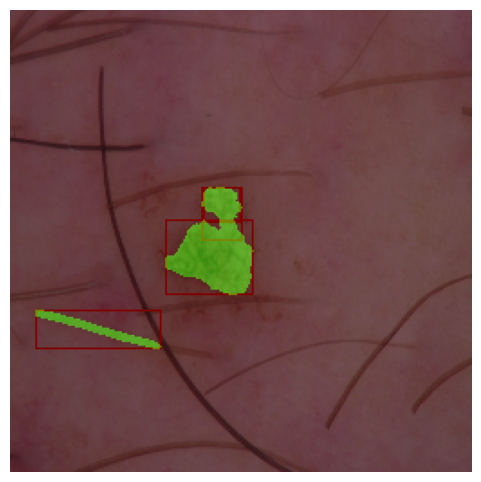

In [22]:
for i in train_data_seg[:2]:
    image_name = i['image']
    indices_list = i['bbox_indices']
    visualize_with_indices(image_name=image_name, indices_list=indices_list)

In [ ]:
# visualize_with_indices(image_name='synpic28602.jpg', indices_list=[3, 8, 9], fig_width=5)

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_with_indices(image_name, indices_list:list = None, indices:tuple = None, width_threshold=260, fig_width=6):
    image_path = os.path.join("/data/aofei/hallucination/HAM10000/images", image_name)
    masks = masks_image_dict[image_path]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_with_boxes = image_rgb.copy()

    # Create an empty mask with the same size as the image
    combined_mask = np.zeros_like(image_rgb, dtype=np.uint8)

    # Loop over all segmentation results
    selected_masks = []
    if indices is not None:
        selected_masks = masks[indices[0]:indices[1]]
    elif indices_list is not None:
        for i in indices_list:
            selected_masks.append(masks[i])

    for seg in selected_masks:
        # Unpack bbox (bounding box)
        x, y, w, h = seg['bbox']
        if w >= width_threshold:
            continue

        # Draw the bounding box (in red)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 1)

        # Extract and resize the segmentation mask
        mask = seg['segmentation'].astype(np.uint8)
        mask = cv2.resize(mask, (image_rgb.shape[1], image_rgb.shape[0]))  # Resize to fit the image

        # Add mask to combined mask (use a different color for each mask if desired)
        color_mask = np.zeros_like(image_rgb)
        color_mask[mask == 1] = [0, 255, 0]  # Green mask for the segment
        combined_mask = np.maximum(combined_mask, color_mask)

    # Blend the original image with the combined mask once
    alpha = 0.5  # Transparency factor
    image_with_masks = cv2.addWeighted(image_with_boxes, 1 - alpha, combined_mask, alpha, 0)

    # Display the image with bounding boxes and masks
    plt.figure(figsize=(fig_width, fig_width))
    plt.imshow(image_with_masks)
    plt.axis('off')  # Turn off axis for clean visualization
    plt.show()